In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import time
from sapy.components import Clock, ProgramCounter, MemoryAddressRegister, \
    RandomAccessMemory, SwitchBoard, RegisterA, RegisterB, \
    RegisterOutput, ArithmeticUnit, RegisterInstruction, Computer


# Hex and Binary Literals in Python

In [3]:
0xF

15

In [4]:
0xFF

255

In [5]:
print(15_000) # underscore as separators are allowed
print(0b1111_1111)

15000
255


You can also format integers to HEX using X

In [6]:
f"{232:X}"

'E8'

# Clocking Signals

In [28]:
clk = Clock()
class DummyComponent():
    def data(self, con=tuple()):
        print("data accessed")
        return 42
    def clock(self, data, con=tuple()):
        print("clock stepped")

dc = DummyComponent()
clk.add_component(dc)

In [29]:
print("step 1: ---------")
clk.step()
print("step 2: ---------")
clk.step()

step 1: ---------
data accessed
------------------------------------------
PCADDRESS: $2A
T0: Data: $2A, Control Word: ('ep', 'lm', 'cp')
clock stepped
step 2: ---------
data accessed
T1: Data: $2A, Control Word: ('er', 'li')
clock stepped


# Program Counter

To enable a component to take an action on a clock, you pass in the correct control bit as a keyword argument. To enable the PC to output to the data but, use the "ep" control bit.

In [30]:
pc = ProgramCounter()

In [31]:
pc.clock()
pc.data()

In [35]:
pc.clock()
pc.data(con=['ep'])

0

In [37]:
pc.clock()
pc.data(con=['ep'])

0

To increment the program counter, the control bit is "cp".

In [46]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

1

In [47]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

2

In [52]:
pc.clock(con=['cp'])
pc.data(con=['ep'])

14

For jump instructions you set the program counter directly. This is done with the "lp" control bit.

In [58]:
pc.clock(data=0xD, con=['lp'])
print(f"0x{pc.data(con=['ep']):02X}")
print(f"{pc.data(con=['ep'])}")

0x0D
13


# Accumulator (Register A)

In [60]:
reg_a = RegisterA()
print(f"The register value on reset is: 0x{reg_a.data(con=['ea']):0X}")

reg_a.clock(data=0xAB, con=['la'])
reg_a.data(con=['ea'])
print(f"The register has latched a value: 0x{reg_a.data(con=['ea']):0X}")


The register value on reset is: 0x0
The register has latched a value: 0xAB


# ALU
## Arithmatic Logic Unit

Some components have extra attributes that allow it to communicate directly to other components outside of the bus. 

The ALU is not clocked, it doesn't even have state. The data output from the ALU is alway the instantaneous sum (or difference) of Reg A + Reg B

In [99]:
reg_a = RegisterA()
reg_a.clock(data=4, con=['la'])

reg_b = RegisterB()
reg_b.clock(data=3, con=['lb'])

alu = ArithmeticUnit(reg_a, reg_b)

alu.data(con=['eu'])

print(f"\t0x{reg_a.value:02X}")
print(f"+\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu']):02X}")

	0x04
+	0x03
------------
	0x07


In [100]:
# change the value of the register feeding the alu
reg_b.clock(data=1, con=['lb'])
alu.data(con=['eu'])

print(f"\t0x{reg_a.value:02X}")
print(f"+\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu']):02X}")

	0x04
+	0x01
------------
	0x05


Subtraction

In [101]:

print(f"\t0x{reg_a.value:02X}")
print(f"-\t0x{reg_b.value:02X}")
print('-' * 12)
print(f"\t0x{alu.data(con=['eu', 'su']):02X}")

	0x04
-	0x01
------------
	0x03


# Memory

Ram is another example of a system that has communication outside the bus, it always access the RAM value stored at the address latched in the Memory Address Register.

In [113]:
mar = MemoryAddressRegister()
ram = RandomAccessMemory(mar)

# store address for ram in register
mar.clock(data=0x0F, con=['lm'])
print(f"Memory Address: 0x{mar.value:02X}")


# clock data into ram at the address set above
ram.clock(data=0xAB, con=['lr'])
assert ram.data() == None
print(f"Memory at address: 0x{mar.value:02X} is 0x{ram.data(con=['er']):02X}") # should be 0xAB
print(f"Memory at address: {mar.value} is {ram.data(con=['er'])}") # just to demystify hex..

Memory Address: 0x0F
Memory at address: 0x0F is 0xAB
Memory at address: 15 is 171


# Controller: Sequencer + Decoder + Clock

In [ ]:
reg_i = RegisterInstruction()
instruction = 0xFF # both opcode and argument, 8bits
reg_i.clock(data=instruction, con=['li'])


In [ ]:
print(f"The opcode is {reg_i.opcode():X}")

# Example Sequencing: LDA

In [ ]:
from sapy import Computer

cpu = Computer()
rom = [
    0x00, 0x09, # 0x0 LDA 09H
    ]
cpu.switches.load_program(rom)

for _ in range(7):
    cpu.step(debug=True) 

In [ ]:
cpu.step(debug=True)

# Output (Register O)

In [ ]:
reg_o = RegisterOutput()
reg_o.clock(data=0x90, con=['lo'])

In [ ]:
# monkey patch output function for fancy display
def display_number(x):
    print(f"***### {x} ###***")
reg_o.output_function = display_number

In [ ]:
reg_o.clock(data=0x90, con=['lo'])

# Full Computer with ROM

In [2]:
from sapy.assembler import assemble

In [102]:
cpu = Computer()
rom = [
    0x00, 0x07, # 0x00 LDA 07H
    0x01, 0x08, # 0x02 ADD 08H
    0xF6,       # 0x04 OTA
    0x04, 0x02, # 0x05 JMP 02H
    0x00,       # 0x07 A1H
    0x03,       # 0x08 22H
    ]
cpu.switches.load_program(rom)

In [103]:
for _ in range(9):
    cpu.step(instructionwise=True)

------------------------------------------
PCADDRESS: $00
T0: Data: $00, Control Word: ('ep', 'lm', 'cp')
T1: Data: $00, Control Word: ('er', 'li')
OPCODE: $00, MNE: LDA
T2: Data: $01, Control Word: ('ep', 'lm', 'cp')
T3: Data: $07, Control Word: ('er', 'lm')
T4: Data: $00, Control Word: ('er', 'la')
------------------------------------------
PCADDRESS: $02
T0: Data: $02, Control Word: ('ep', 'lm', 'cp')
T1: Data: $01, Control Word: ('er', 'li')
OPCODE: $01, MNE: ADD
T2: Data: $03, Control Word: ('ep', 'lm', 'cp')
T3: Data: $08, Control Word: ('er', 'lm')
T4: Data: $03, Control Word: ('er', 'lb')
T5: Data: $03, Control Word: ('eu', 'la')
------------------------------------------
PCADDRESS: $04
T0: Data: $04, Control Word: ('ep', 'lm', 'cp')
T1: Data: $F6, Control Word: ('er', 'li')
OPCODE: $F6, MNE: OTA
T2: Data: $03, Control Word: ('ea', 'lo')
Output Display: 3
------------------------------------------
PCADDRESS: $05
T0: Data: $05, Control Word: ('ep', 'lm', 'cp')
T1: Data: $04, Con

KeyError: 4

In [104]:
for _ in range(3):
    cpu.step(instructionwise=True, debug=True)

T1: Data: $04, Control Word: ('er', 'li')
Trying to execute a non-existant opcode


KeyError: 4

In [ ]:
import ipywidgets as widgets
from IPython.display import display
gui_output_display = widgets.FloatText()
display(gui_output_display)

# monkey patch output function
def display_number(x):
    gui_output_display.value = x

cpu.reg_o.output_function = display_number

In [ ]:
for _ in range(3):
    time.sleep(.2)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
for _ in range(27):
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
while True:
    time.sleep(.03)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
cpu = Computer()
rom = [
    0x00, 0x09, # 0x00 LDA   09H
    0x01, 0x0A, # 0x20 ADD  0AH
    0xF6,       # 0x04 OTA
    0x05, 0x0A, # 0x05 STA  0AH
    0x04, 0x02, # 0x07 JMP $02H
    0x01,       # 0x09 01H
    0x02,       # 0x0A 02H
    ]

cpu.switches.load_program(rom)
#cpu.reset()

In [ ]:
import ipywidgets as widgets
from IPython.display import display
gui_output_display = widgets.FloatText()
display(gui_output_display)

# monkey patch output function
def display_number(x):
    gui_output_display.value = x

cpu.reg_o.output_function = display_number

In [ ]:
while True:
    time.sleep(.2)
    cpu.step(instructionwise=True, debug=True)

In [ ]:
cpu.step(instructionwise=True, debug=True)

# DMA

In [38]:
%matplotlib notebook

In [39]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [43]:
cpu = Computer()
countup = [
    0x20, 0x99, # 0x00 LDA #$99
    0x21, 0x09, # 0x20 ADD #$0A
    0xFD,       # 0x04 DMA
    0x05, 0x4A, # 0x05 STA  $4A
    0x34, 0x02, # 0x07 JMP  $02
    ]
moveacross = [
    0x20, 0x10, # 0x00 LDA #$10
    0x21, 0x03, # 0x20 ADD #$03
    0xFD,       # 0x04 DMA
    0x35, 0x0B, # 0x05 STA  $0B
    0x45, 0x0B, # 0x07 STA ($0B)
    0x34, 0x02, # 0x09 JMP  $02
    ]
moveacross = """
    LDA #$10
    ADD #$03
    DMA
    STA  $0B
    STA ($0B)
    JMP  $02
    """
instructions = [i.strip() for i in moveacross.split('\n') if i.strip() != '']
moveacross_bytes = assemble(instructions)
for address, byte in enumerate(moveacross_bytes):
    print(f"0x{address:02X}\t${byte:02X}")
cpu.switches.load_program(moveacross_bytes)

0x00	$20
0x01	$10
0x02	$21
0x03	$03
0x04	$FD
0x05	$35
0x06	$0B
0x07	$45
0x08	$0B
0x09	$34
0x0A	$02


<IPython.core.display.Javascript object>


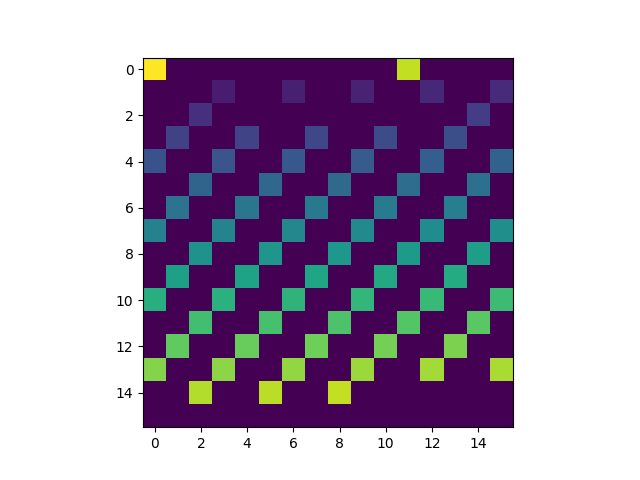

In [44]:
plt.ion()
fig, ax = plt.subplots(1,1)
initial_bitmap = np.zeros((0xF + 1, 0xF + 1))
initial_bitmap[0,0] = 0xFF # get the color map set
heatmap = ax.imshow(initial_bitmap)
plt.show()

def plt_memory(bitmap):
    heatmap.set_data(bitmap)
    fig.canvas.draw()
    
cpu.dma.connect_dma_handler(plt_memory)

In [19]:
cpu.step(instructionwise=True, debug=True)

------------------------------------------
PCADDRESS: $00
T0: Data: $00, Control Word: ('ep', 'lm', 'cp')
T1: Data: $20, Control Word: ('er', 'li')
OPCODE: $20, MNE: LDA
T2: Data: $01, Control Word: ('ep', 'lm', 'cp')
T3: Data: $10, Control Word: ('er', 'la')


In [45]:
n = 0
for i in range(363):
#while True:
    #time.sleep(0.001)
    n += 1
    if n % 50 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

50
100
150
200
250
300
350


In [ ]:
plt.show()

In [ ]:
while True:
    time.sleep(0.001)
    n += 1
    if n % 100 == 0:
        print(n)
    cpu.step(instructionwise=True, debug=False)

In [ ]:
#var name test
LDA

In [ ]:
0xF3 >> 4